# 使用 VideoDecoder 解码视频

本示例演示如何使用 `torchcodec.decoders.VideoDecoder` 类解码视频。

## 准备工作

首先从网络下载一个示例视频，并定义一个绘图工具函数。如果你只关心解码步骤，可直接跳到下方的“创建解码器”。

In [1]:
from typing import Optional
import torch
import httpx

# 视频来源: https://www.pexels.com/video/dog-eating-854132/
# 许可: CC0. 作者: Coverr.
url = "https://videos.pexels.com/video-files/854132/854132-sd_640_360_25fps.mp4"
response = httpx.get(url, headers={"User-Agent": ""})
if response.status_code != 200:
    raise RuntimeError(f"Failed to download video. {response.status_code = }.")

raw_video_bytes = response.content

In [2]:
def plot(frames: torch.Tensor, title: Optional[str] = None):
    try:
        from torchvision.utils import make_grid
        from torchvision.transforms.v2.functional import to_pil_image
        import matplotlib.pyplot as plt
    except ImportError:
        print("Cannot plot, please run `pip install torchvision matplotlib`")
        return

    plt.rcParams["savefig.bbox"] = 'tight'
    fig, ax = plt.subplots()
    ax.imshow(to_pil_image(make_grid(frames)))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()

In [3]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import os

def _set_chinese_font():
    candidates = [
        "Microsoft YaHei",
        "Microsoft JhengHei",
        "SimHei",
        "SimSun",
        "Noto Sans CJK SC",
        "Noto Sans CJK JP",
        "Source Han Sans SC",
        "PingFang SC",
        "Arial Unicode MS",
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = [name]
            plt.rcParams['axes.unicode_minus'] = False
            return name
    win_fonts = [
        r"C:\Windows\Fonts\msyh.ttc",
        r"C:\Windows\Fonts\simhei.ttf",
        r"C:\Windows\Fonts\simsun.ttc",
    ]
    for path in win_fonts:
        if os.path.exists(path):
            font_manager.fontManager.addfont(path)
            font_name = font_manager.FontProperties(fname=path).get_name()
            plt.rcParams['font.family'] = 'sans-serif'
            plt.rcParams['font.sans-serif'] = [font_name]
            plt.rcParams['axes.unicode_minus'] = False
            return font_name
    print('Warning: 未找到中文字体，可能出现缺字警告。')
    return None

_chinese_font = _set_chinese_font()
if _chinese_font:
    print(f'已使用中文字体: {_chinese_font}')


已使用中文字体: Microsoft YaHei


## 创建解码器

我们可以直接从原始（编码）视频字节创建解码器。你也可以使用本地视频文件路径作为输入。

In [4]:
from torchcodec.decoders import VideoDecoder

decoder = VideoDecoder(raw_video_bytes)

视频尚未被真正解码，但我们可以通过 `metadata` 属性（类型为 `torchcodec.decoders.VideoStreamMetadata`）读取一些元数据。

In [5]:
print(decoder.metadata)

VideoStreamMetadata:
  duration_seconds_from_header: 13.8
  begin_stream_seconds_from_header: 0.0
  bit_rate: 505790.0
  codec: h264
  stream_index: 0
  begin_stream_seconds_from_content: 0.0
  end_stream_seconds_from_content: 13.8
  width: 640
  height: 360
  num_frames_from_header: 345
  num_frames_from_content: 345
  average_fps_from_header: 25.0
  pixel_aspect_ratio: 1
  duration_seconds: 13.8
  begin_stream_seconds: 0.0
  end_stream_seconds: 13.8
  num_frames: 345
  average_fps: 25.0



## 通过下标解码帧

索引解码器即可得到帧的 `torch.Tensor`：默认返回形状为 `N, C, H, W`（批大小、通道数、高、宽）。当解码多个帧时才会出现批维 `N`。可以通过在创建解码器时设置 `dimension_order` 参数改为 `N, H, W, C`。帧的 dtype 始终为 `torch.uint8`。

如果需要一次解码多个帧，推荐使用批量 API（更快）：`VideoDecoder.get_frames_at`、`VideoDecoder.get_frames_in_range`、`VideoDecoder.get_frames_played_at`、`VideoDecoder.get_frames_played_in_range`。

In [6]:
first_frame = decoder[0]
every_twenty_frame = decoder[0:-1:20]

print(f"{first_frame.shape = }")
print(f"{first_frame.dtype = }")
print(f"{every_twenty_frame.shape = }")
print(f"{every_twenty_frame.dtype = }")

first_frame.shape = torch.Size([3, 360, 640])
first_frame.dtype = torch.uint8
every_twenty_frame.shape = torch.Size([18, 3, 360, 640])
every_twenty_frame.dtype = torch.uint8


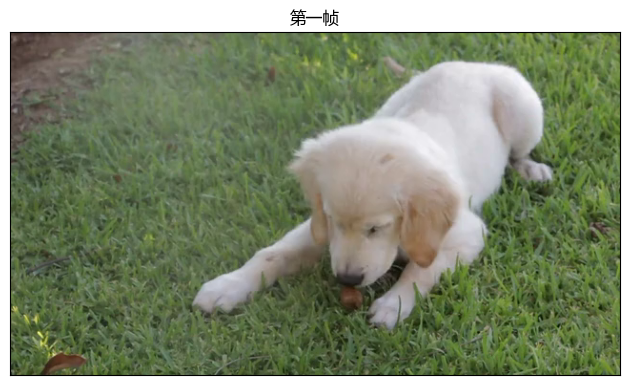

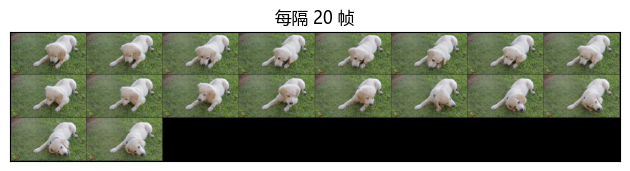

In [7]:
plot(first_frame, "第一帧")
plot(every_twenty_frame, "每隔 20 帧")

## 迭代帧

解码器是一个可迭代对象，可以直接遍历：

In [8]:
for frame in decoder:
    assert (
        isinstance(frame, torch.Tensor)
        and frame.shape == (3, decoder.metadata.height, decoder.metadata.width)
    )

## 获取帧的 pts 和时长

索引返回的是纯 `torch.Tensor`。如果还需要获取帧的展示时间戳（pts）和时长，可使用 `VideoDecoder.get_frame_at` 与 `VideoDecoder.get_frames_at`，它们分别返回 `torchcodec.Frame` 与 `torchcodec.FrameBatch`。

In [9]:
last_frame = decoder.get_frame_at(len(decoder) - 1)
print(f"{type(last_frame) = }")
print(last_frame)

type(last_frame) = <class 'torchcodec._frame.Frame'>
Frame:
  data (shape): torch.Size([3, 360, 640])
  pts_seconds: 13.76
  duration_seconds: 0.04



In [10]:
other_frames = decoder.get_frames_at([10, 0, 50])
print(f"{type(other_frames) = }")
print(other_frames)

type(other_frames) = <class 'torchcodec._frame.FrameBatch'>
FrameBatch:
  data (shape): torch.Size([3, 3, 360, 640])
  pts_seconds: tensor([0.4000, 0.0000, 2.0000], dtype=torch.float64)
  duration_seconds: tensor([0.0400, 0.0400, 0.0400], dtype=torch.float64)



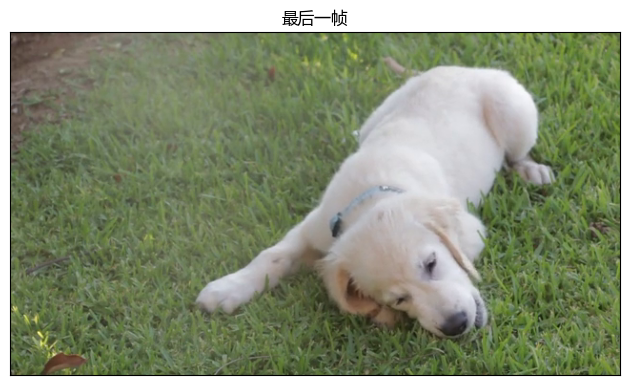

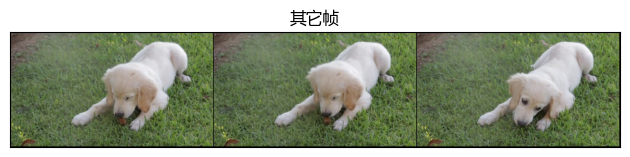

In [11]:
plot(last_frame.data, "最后一帧")
plot(other_frames.data, "其它帧")

`Frame` 与 `FrameBatch` 都包含 `data` 字段（解码后的张量数据），以及 `pts_seconds` 和 `duration_seconds` 字段：对于 `Frame` 是单个数值；对于 `FrameBatch` 是一维 `torch.Tensor`（与批中帧一一对应）。

## 基于播放时间检索帧

除了按索引检索之外，还可以根据帧的播放时间检索：`VideoDecoder.get_frame_played_at` 与 `VideoDecoder.get_frames_played_at`，同样分别返回 `Frame` 与 `FrameBatch`。

In [12]:
frame_at_2_seconds = decoder.get_frame_played_at(seconds=2)
print(f"{type(frame_at_2_seconds) = }")
print(frame_at_2_seconds)

type(frame_at_2_seconds) = <class 'torchcodec._frame.Frame'>
Frame:
  data (shape): torch.Size([3, 360, 640])
  pts_seconds: 2.0
  duration_seconds: 0.04



In [13]:
other_frames = decoder.get_frames_played_at(seconds=[10.1, 0.3, 5])
print(f"{type(other_frames) = }")
print(other_frames)

type(other_frames) = <class 'torchcodec._frame.FrameBatch'>
FrameBatch:
  data (shape): torch.Size([3, 3, 360, 640])
  pts_seconds: tensor([10.0800,  0.2800,  5.0000], dtype=torch.float64)
  duration_seconds: tensor([0.0400, 0.0400, 0.0400], dtype=torch.float64)



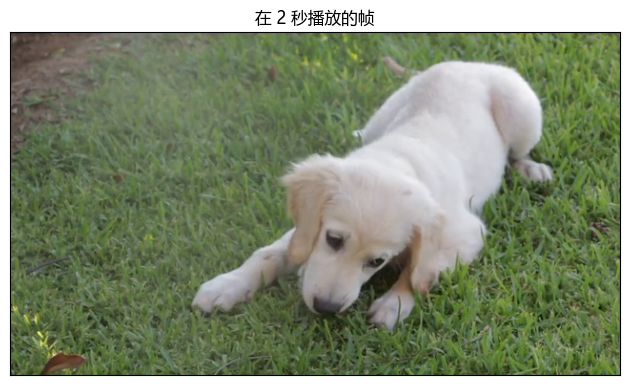

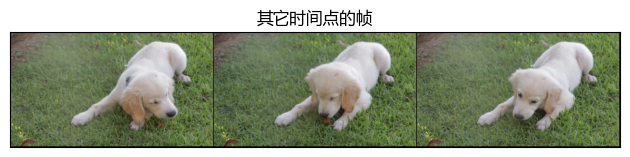

In [14]:
plot(frame_at_2_seconds.data, "在 2 秒播放的帧")
plot(other_frames.data, "其它时间点的帧")